In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pycbc
from pycbc.types import FrequencySeries
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from gstlal import chirptime
from functools import partial


import h5py
import scipy

In [3]:
def make_td_waveform(
        mass1, mass2,
        distance, inclination, coa_phase,
        spin1x, spin1y, spin1z,
        spin2x, spin2y, spin2z,
        delta_t, f_lower,
        approximant='IMRPhenomPv2'):
    
    hp, hc = get_td_waveform(approximant='IMRPhenomPv2',\
        mass1=mass1, mass2=mass2,\
        distance=distance,\
        inclination=inclination, coa_phase=coa_phase,\
        spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,\
        spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,\
        delta_t=delta_t, f_lower=f_lower)
    
    
    hp.start_time=0
    hc.start_time=0
    start_time = 0
    end_time = len(hp)*delta_t
    
    MSUN_KG = chirptime.Msun
    ringtime = chirptime.ringtime(60*MSUN_KG, spin1z+spin2z)
    #if ringtime<end_time:
    #    end_time=ringtime
    
    timeshift = np.argmax(hp-1j*hc)*delta_t  # make sure h=hmax when t=0
    timestamp = np.linspace(start_time, end_time, len(hp))-timeshift
    
    mask = timestamp<ringtime
    
    return timestamp[mask], hp[mask]

In [4]:
# rescale
def f_of_tau(tau, chirp_mass):
    '''Eq 4.20 of GW'''
    return 134 * (1.21/chirp_mass)**(5/8) * (1/tau)**(3/8)


def tau_of_f(f, chirp_mass):
    '''Eq 4.21 of GW'''
    return 2.18*(1.21/chirp_mass)**(5/3)*(100/f)**(8/3)


def sampling_density(t, m1, m2, a1, a2, t_start, t_end):    
    total_mass = m1+m2
    chirp_mass = (m1*m2)**(3/5) / total_mass**(1/5)
    
    MSUN_KG = chirptime.Msun
    time_ISCO_2_merger = -chirptime.mergetime(total_mass*MSUN_KG)  # <0 (?)
    #time_ringdown = chirptime.ringtime(total_mass*MSUN_KG, a1+a2)  # >0
    
    time_ringdown = t_end
    #t_end = min(time_ringdown, t_end)
    #time_ringdown = min(time_ringdown, t_end)
    
    freq_ISCO = f_of_tau(-time_ISCO_2_merger, chirp_mass)
    freq_ringdown = chirptime.ringf(total_mass*MSUN_KG, a1+a2)
    
    # *assume* :
    # t in [-inf, time_ISCO_2_merger]: sample density ~ |t|^(-3/8) 
    # t in [time_ISCO_2_merger, t_end]: sample density ~ freq, where freq goes from freq_ISCO to freq_ringdown
    # rho \propto f
    
    b = (-time_ISCO_2_merger) ** (-3/8)
    eta = freq_ringdown/freq_ISCO
    k = b*(eta-1)/(t_end-time_ISCO_2_merger)
    
    # normalize so that \int_{t_start}^{t_end} \rho(t) dt = 1
    C = 8/5*(-t_start)**(5/8) - 8/5*(-time_ISCO_2_merger)**(5/8) + 1/2*b*(1+eta)*(t_end-time_ISCO_2_merger)
    C = 1/C
    
    if t<time_ISCO_2_merger:
        return C*(-t)**(-3/8)
    else:
        return C* (k*(t-time_ISCO_2_merger)+b)
    
    
def sampling_density_fullarray(t, m1, m2, a1, a2, t_start, t_end):    
    total_mass = m1+m2
    chirp_mass = (m1*m2)**(3/5) / total_mass**(1/5)
    
    MSUN_KG = chirptime.Msun
    time_ISCO_2_merger = -chirptime.mergetime(total_mass*MSUN_KG)  # <0 (?)
    #time_ringdown = chirptime.ringtime(total_mass*MSUN_KG, a1+a2)  # >0
    
    time_ringdown = t_end
    #t_end = min(time_ringdown, t_end)
    #time_ringdown = min(time_ringdown, t_end)
    
    freq_ISCO = f_of_tau(-time_ISCO_2_merger, chirp_mass)
    freq_ringdown = chirptime.ringf(total_mass*MSUN_KG, a1+a2)
    
    # *assume* :
    # t in [-inf, time_ISCO_2_merger]: sample density ~ |t|^(-3/8) 
    # t in [time_ISCO_2_merger, t_end]: sample density ~ freq, where freq goes from freq_ISCO to freq_ringdown
    # rho \propto f
    
    b = (-time_ISCO_2_merger) ** (-3/8)
    eta = freq_ringdown/freq_ISCO
    k = b*(eta-1)/(t_end-time_ISCO_2_merger)
    
    # normalize so that \int_{t_start}^{t_end} \rho(t) dt = 1
    C = 8/5*(-t_start)**(5/8) - 8/5*(-time_ISCO_2_merger)**(5/8) + 1/2*b*(1+eta)*(t_end-time_ISCO_2_merger)
    C = 1/C
    
    mask1 = t<time_ISCO_2_merger
    t1 = t[mask1]
    rho1 = C*(-t1)**(-3/8)
    
    mask2 = t>=time_ISCO_2_merger
    t2 = t[mask2]
    rho2 =C* (k*(t2-time_ISCO_2_merger)+b)
    
    
    return np.append(rho1,rho2)
    
    
def real2training_stretch(timestamp, h, m1, m2, a1, a2, ref_freq=50):
    t_start = timestamp[0]
    t_end = timestamp[-1]
    dt = timestamp[1] - timestamp[0]
    ntime = len(timestamp)
    
    chirp_mass = (m1*m2)**(3/5) / (m1+m2)**(1/5)
    
    tr = tau_of_f(ref_freq, chirp_mass)
    index = np.argmin(abs(timestamp-tr))
    tr_in_sample = timestamp[index]
    
    fr_density = sampling_density(tr_in_sample, m1, m2, a1, a2, t_start, t_end)
    freq_array = sampling_density_fullarray(timestamp, m1, m2, a1, a2, t_start, t_end)/fr_density*ref_freq
    freq_array1 = freq_array[:index][::-1]
    freq_array2 = freq_array[index+1:]
    
    accu_freq_1 = -np.add.accumulate(freq_array1)[::-1]
    accu_freq_2 = np.add.accumulate(freq_array2)
    accu_freq = np.append(accu_freq_1,0)
    accu_freq = np.append(accu_freq,accu_freq_2)
    
    new_timestamp = np.zeros(ntime) + tr_in_sample + accu_freq*dt/ref_freq
    
    adjusted_timestamp = new_timestamp*10
    adjusted_h = h*1e19

    return adjusted_timestamp, adjusted_h
def rejection_sampling(pdf_func, xmin, xmax, Nsample, ymax=None):
    '''
    Rejection sampling for 1-D pdf (can be non-normalized).
    
    Can be optimized for efficiency (especially at low pdf region), but I am too lazy.
    '''
    samples = []
    if ymax is None:
        x_array = np.linspace(xmin, xmax, 1000)
        test_pdf = []
        for temp_x in x_array:
            test_pdf.append(pdf_func(temp_x))
        pdf_max = max(test_pdf)
    else:
        pdf_max = ymax
    
    #def g(x):
    #    return pdf_func(x)*1.2
    g = pdf_max*1.05
    while(len(samples)<Nsample):
        xi = np.random.uniform(low=xmin, high=xmax)
        eta = np.random.uniform(low=0, high=g)
        if eta<pdf_func(xi):
            samples.append(xi)
            
    return np.array(samples)

def real2training_resample(timestamp, h, m1, m2, a1, a2):
    t_start = timestamp[0]
    t_end = timestamp[-1]
    ntime = len(timestamp)
    pdf = partial(sampling_density, m1=m1, m2=m2, a1=0, a2=0, t_start=t_start, t_end=t_end)
    timestamp_resampled = rejection_sampling(pdf, t_start, t_end, ntime)
    timestamp_resampled = np.sort(timestamp_resampled)
    hp_interp = np.interp(timestamp_resampled, timestamp, h)

    adjusted_timestamp = timestamp_resampled*100
    adjusted_h = hp_interp*1e19

    return adjusted_timestamp, adjusted_h

In [5]:
def real2training_stretch_resample(timestamp, h, m1, m2, a1, a2, ref_freq=50):
    t_start = timestamp[0]
    t_end = timestamp[-1]
    dt = timestamp[1] - timestamp[0]
    ntime = len(timestamp)
    
    chirp_mass = (m1*m2)**(3/5) / (m1+m2)**(1/5)
    
    tr = tau_of_f(ref_freq, chirp_mass)
    index = np.argmin(abs(timestamp-tr))
    tr_in_sample = timestamp[index]
    
    fr_density = sampling_density(tr_in_sample, m1, m2, a1, a2, t_start, t_end)
    freq_array = sampling_density_fullarray(timestamp, m1, m2, a1, a2, t_start, t_end)/fr_density*ref_freq
    freq_array1 = freq_array[:index][::-1]
    freq_array2 = freq_array[index+1:]
    
    accu_freq_1 = -np.add.accumulate(freq_array1)[::-1]
    accu_freq_2 = np.add.accumulate(freq_array2)
    accu_freq = np.append(accu_freq_1,0)
    accu_freq = np.append(accu_freq,accu_freq_2)
    
    new_timestamp = np.zeros(ntime) + tr_in_sample + accu_freq*dt/ref_freq
    
    stretched_timestamp = new_timestamp*10
    stretched_h = h*1e19
    
    resampled_timestamp = np.linspace(stretched_timestamp[0], stretched_timestamp[-1], len(stretched_timestamp))
    interpolator = scipy.interpolate.CubicSpline(stretched_timestamp, stretched_h)  # CubicSpline, interp1d
    resampled_h = interpolator(resampled_timestamp)
    #resampled_h = np.interp(resampled_timestamp, stretched_timestamp, stretched_h)
    
    return stretched_timestamp, stretched_h, resampled_timestamp, resampled_h

# Method 1: Stretch waveforms

## Test

In [4]:
Mtot=60
q=0.5 # q=m2/m1<1

mass_1 = Mtot/(1+q)
mass_2 = mass_1*q


luminosity_distance = 1
iota = 0
phase = 0
spin1x,spin1y,spin1z = [0.,0.,0.]
spin2x,spin2y,spin2z = [0.,0.,0.]

deltat = 1/4096
flow = 20

In [5]:
timestamp, hp = make_td_waveform(mass1=mass_1, mass2=mass_2,\
        distance=luminosity_distance,\
        inclination=iota, coa_phase=phase,\
        spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,\
        spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,\
        delta_t=deltat, f_lower=flow)

(-0.1, 0.1)

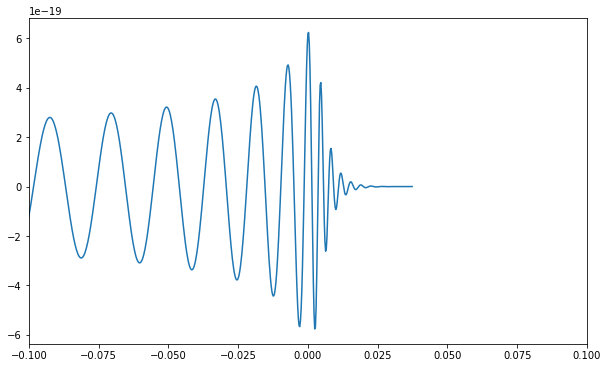

In [6]:
plt.figure(figsize=(10,6))
plt.plot(timestamp,hp)
plt.xlim(-0.1,0.1)

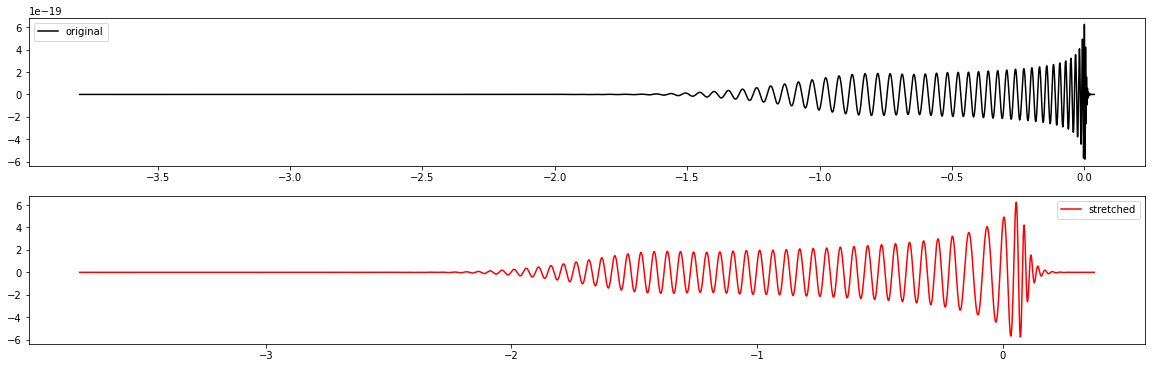

In [8]:
m1 = Mtot/(1+q)
m2 = q*Mtot/(1+q)
a1 = 0
a2 = 0
chirp_mass = (m1*m2)**(3/5) / (m1+m2)**(1/5)

ref_freq = 50

adjusted_timestamp, adjusted_h = real2training_stretch(timestamp, hp, m1, m2, a1, a2, ref_freq=ref_freq)

plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.plot(timestamp,hp, color='k',label='original')
plt.legend()

plt.subplot(2,1,2)
plt.plot(adjusted_timestamp,adjusted_h, color='r',label='stretched')

#plt.xlim(-50,3)
plt.legend()

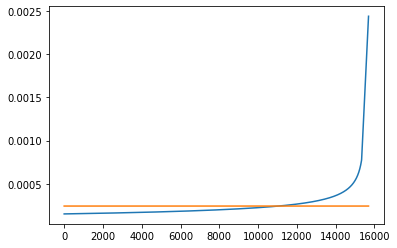

In [9]:
plt.plot(np.diff(adjusted_timestamp))
plt.plot(np.diff(timestamp))

## Save

Good habit: restart kernel, run imports & defs, and run from there

In [4]:
N=100
#q_train = np.logspace(np.log10(0.5),0,N)  # q from 0.5 to 1
q_train = np.linspace(0.7,1,N)

In [5]:
Mtot=60

mass_1_train = Mtot/(1+q_train)
mass_2_train = mass_1_train*q_train

luminosity_distance = 1
iota = 0
phase = 0
spin1x,spin1y,spin1z = [0.,0.,0.]
spin2x,spin2y,spin2z = [0.,0.,0.]

deltat = 1/4096
flow = 20


In [6]:
data_dict = dict()
data_dict['time'] = []
data_dict['strain'] = []
data_dict['source_parameters'] = dict()
parameter_name_list = ['mass1','mass2','spin1x','spin1y','spin1z','spin2x','spin2y','spin2z']
for paraname in parameter_name_list:
    data_dict['source_parameters'][paraname] = []


In [7]:
def padding_data_dict(data_dict):
    time = data_dict['time']
    lengths = []
    for t in time:
        lengths.append(len(t))
    max_length = max(lengths)
    
    for i in range(len(data_dict['time'])):
        temp_len = lengths[i]
        len_diff = max_length-temp_len
        if len_diff>0:
            paddings = np.full(len_diff, np.nan)
            data_dict['strain'][i] = np.append(data_dict['strain'][i], paddings)
            data_dict['time'][i] = np.append(data_dict['time'][i], paddings)
            
    return data_dict

def trimming_data_dict(data_dict):
    time = data_dict['time']
    lengths = []
    for t in time:
        lengths.append(len(t))
    min_length = min(lengths)
    
    for i in range(len(time)):
        temp_len = lengths[i]
        len_diff = temp_len - min_length
        if len_diff>0:
            index_to_delete = np.random.permutation(temp_len//10)
            index_to_delete = index_to_delete[:len_diff]
            data_dict['strain'][i] = np.delete(data_dict['strain'][i], index_to_delete)
            data_dict['time'][i] = np.delete(data_dict['time'][i], index_to_delete)
            
    return data_dict

In [8]:
#np.savetxt('training_data_1d_stretched/training_q.txt', q_train)

waveform_index = 0
wfl = []
for waveform_index in range(N):
    mass_1_temp = mass_1_train[waveform_index]
    mass_2_temp = mass_2_train[waveform_index]
    
    timestamp_temp, hp_temp = make_td_waveform(mass1=mass_1_temp, mass2=mass_2_temp,\
        distance=1,\
        inclination=0, coa_phase=0,\
        spin1x=0, spin1y=0, spin1z=0,\
        spin2x=0, spin2y=0, spin2z=0,\
        delta_t=deltat, f_lower=flow)
    
    wfl.append(len(timestamp_temp))
    timestamp_temp, hp_temp = real2training_stretch(timestamp_temp, hp_temp, mass_1_temp, mass_2_temp, 0, 0)
    stacked_waveform = np.stack((timestamp_temp,hp_temp),axis=-1)
    #all_waveform_stretched = all_waveform_stretched.add(pd.DataFrame(data=hp_temp, index=timestamp_temp))
    #np.savetxt('training_data_1d_stretched/waveform{}.txt'.format(waveform_index), stacked_waveform)
    
    data_dict['time'].append(timestamp_temp)
    data_dict['strain'].append(hp_temp)
    data_dict['source_parameters']['mass1'].append(mass_1_temp)
    data_dict['source_parameters']['mass2'].append(mass_2_temp)
    
    data_dict['source_parameters']['spin1x'].append(0)
    data_dict['source_parameters']['spin1y'].append(0)
    data_dict['source_parameters']['spin1z'].append(0)
    data_dict['source_parameters']['spin2x'].append(0)
    data_dict['source_parameters']['spin2y'].append(0)
    data_dict['source_parameters']['spin2z'].append(0)
    
    
    #plt.subplot(N//2+1,2,waveform_index+1)
    #plt.title("q={}".format(q_train[waveform_index]))
    #plt.plot(timestamp,hp_temp)
    
#plt.show()


In [9]:
#data_dict = padding_data_dict(data_dict)
data_dict = trimming_data_dict(data_dict)

In [10]:
#h5filename = 'training_data_1d_stretched/gw_stretched_dim1_N100.h5'
h5filename = '/home/qian.hu/neuron_process_waveform/test_1d_q/training_data/gw_stretched_dim1_qp71_N100_trim.h5'

with h5py.File(h5filename, 'w') as file:
    file.create_dataset('time', data=data_dict['time'])
    file.create_dataset('strain', data=data_dict['strain'])
    grp = file.create_group("source_parameters")
    for paraname in parameter_name_list:
        grp.create_dataset(paraname, data=data_dict['source_parameters'][paraname])

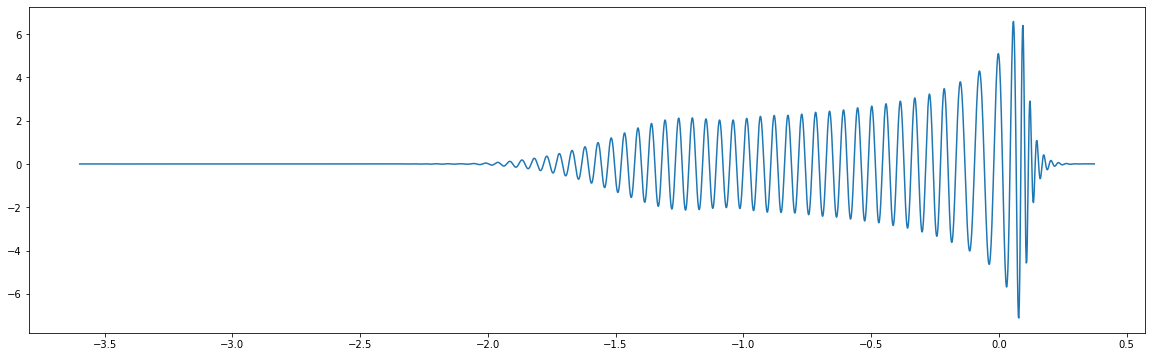

In [8]:
plt.figure(figsize=(20,6))
plt.plot(timestamp_temp, hp_temp)

# Method 2: Resample waveforms

## Test

In [15]:
Mtot=60
q=0.5 # q=m2/m1<1

mass_1 = Mtot/(1+q)
mass_2 = mass_1*q


luminosity_distance = 1
iota = 0
phase = 0
spin1x,spin1y,spin1z = [0.,0.,0.]
spin2x,spin2y,spin2z = [0.,0.,0.]

deltat = 1/4096
flow = 20

In [16]:
timestamp, hp = make_td_waveform(mass1=mass_1, mass2=mass_2,\
        distance=luminosity_distance,\
        inclination=iota, coa_phase=phase,\
        spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,\
        spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,\
        delta_t=deltat, f_lower=flow)

(-0.1, 0.1)

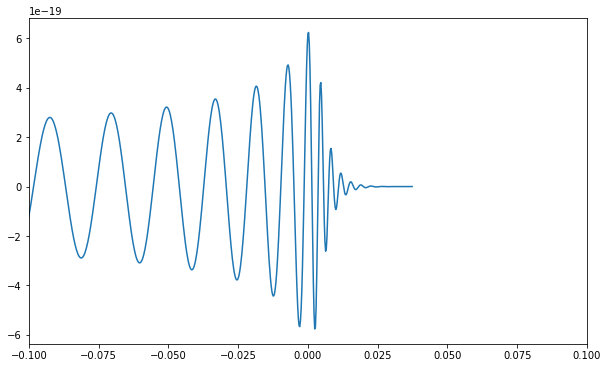

In [17]:
plt.figure(figsize=(10,6))
plt.plot(timestamp,hp)
plt.xlim(-0.1,0.1)

(-20.0, 8.0)

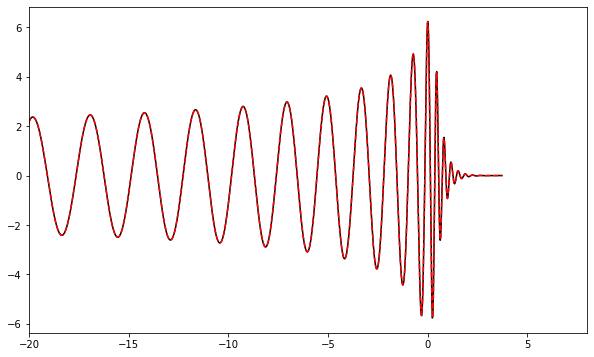

In [20]:
ntime = len(timestamp)
Mtot=60
q=0.5 # q=m2/m1<1

mass_1 = Mtot/(1+q)
mass_2 = mass_1*q

timestamp_resampled, hp_interp = real2training_resample(timestamp, hp, mass_1, mass_2, 0, 0)


plt.figure(figsize=(10,6))
plt.plot(timestamp*100,hp*1e19, color='k')
#plt.scatter(timestamp_resampled,hp_interp, color='r',s=2)
plt.plot(timestamp_resampled,hp_interp, color='r',linestyle='--')

plt.xlim(-20,8)

1.0003140192061424


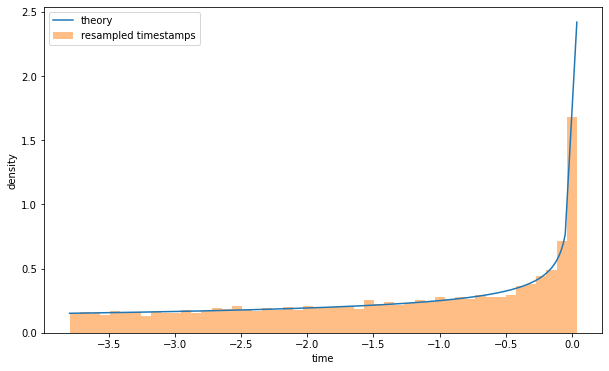

In [21]:
intgral = 0
t_start = timestamp[0]
t_end = timestamp[-1]
dt = timestamp[1]-timestamp[0]

rho = []

for tt in timestamp:
    integrand = sampling_density(tt, mass_1, mass_2, 0, 0, t_start, t_end )
    rho.append(integrand)
    intgral += integrand*dt
    
print(intgral)
plt.figure(figsize=(10,6))
plt.plot(timestamp, rho, label='theory')
plt.hist(timestamp_resampled/100, density=True, bins=50, label='resampled timestamps',alpha=0.5)
plt.xlabel('time')
plt.ylabel('density')
plt.legend()
plt.show()

## Save

Again, restart kernel pls

In [4]:
N=15
#q_train = np.logspace(np.log10(0.5),0,N)  # q from 0.5 to 1
q_train = np.linspace(0.5,1,N)

In [5]:
q_train

array([0.5       , 0.53571429, 0.57142857, 0.60714286, 0.64285714,
       0.67857143, 0.71428571, 0.75      , 0.78571429, 0.82142857,
       0.85714286, 0.89285714, 0.92857143, 0.96428571, 1.        ])

In [6]:
Mtot=60

mass_1_train = Mtot/(1+q_train)
mass_2_train = mass_1_train*q_train

luminosity_distance = 1
iota = 0
phase = 0
spin1x,spin1y,spin1z = [0.,0.,0.]
spin2x,spin2y,spin2z = [0.,0.,0.]

deltat = 1/4096
flow = 20


In [7]:
np.savetxt('training_data_1d_resampled/training_q.txt', q_train)

waveform_index = 0
#plt.figure(figsize=(20,N*2))
for waveform_index in range(N):
    mass_1_temp = mass_1_train[waveform_index]
    mass_2_temp = mass_2_train[waveform_index]
    
    timestamp_temp, hp_temp = make_td_waveform(mass1=mass_1_temp, mass2=mass_2_temp,\
        distance=1,\
        inclination=0, coa_phase=0,\
        spin1x=0, spin1y=0, spin1z=0,\
        spin2x=0, spin2y=0, spin2z=0,\
        delta_t=deltat, f_lower=flow)
    
    
    timestamp_temp, hp_temp = real2training_resample(timestamp_temp, hp_temp, mass_1_temp, mass_2_temp, spin1z, spin2z)
    np.savetxt('training_data_1d_resampled/waveform{}.txt'.format(waveform_index), np.stack((timestamp_temp,hp_temp),axis=-1))
    
    #plt.subplot(N//2+1,2,waveform_index+1)
    #plt.title("q={}".format(q_train[waveform_index]))
    #plt.plot(timestamp,hp_temp)
    
#plt.show()


(-10.0, 8.0)

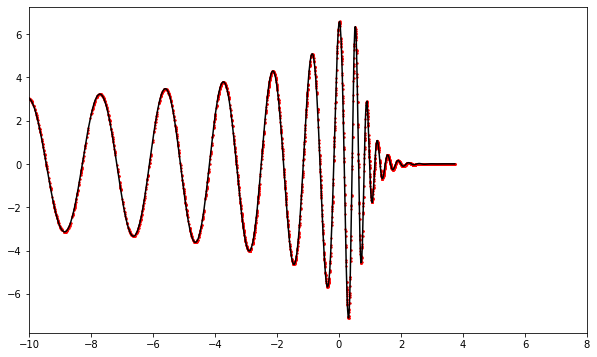

In [8]:
m1 = mass_1_temp
m2 = mass_2_temp
a1 = 0
a2 = 0
chirp_mass = (m1*m2)**(3/5) / (m1+m2)**(1/5)

plt.figure(figsize=(10,6))
plt.plot(timestamp_temp,hp_temp, color='k')
plt.scatter(timestamp_temp, hp_temp, s=2, color='r')
plt.xlim(-10,8)

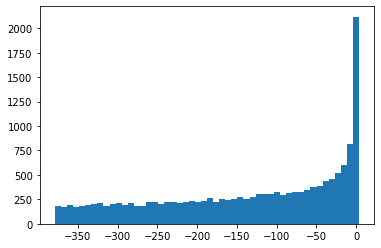

In [9]:
x,xx,xxx = plt.hist(timestamp_temp, bins=50)

# Method 1+2: resample then stretch

In [6]:
N=100
#q_train = np.logspace(np.log10(0.5),0,N)  # q from 0.5 to 1
q_train = np.linspace(0.7,1,N)

Mtot=60

mass_1_train = Mtot/(1+q_train)
mass_2_train = mass_1_train*q_train

luminosity_distance = 1
iota = 0
phase = 0
spin1x,spin1y,spin1z = [0.,0.,0.]
spin2x,spin2y,spin2z = [0.,0.,0.]

deltat = 1/4096
flow = 20

data_dict = dict()
data_dict['time_stretched'] = []
data_dict['strain_stretched'] = []
data_dict['time_stretched_resampled'] = []
data_dict['strain_stretched_resampled'] = []

data_dict['source_parameters'] = dict()
parameter_name_list = ['mass1','mass2','spin1x','spin1y','spin1z','spin2x','spin2y','spin2z']
for paraname in parameter_name_list:
    data_dict['source_parameters'][paraname] = []

In [7]:
def padding_data_dict(data_dict):
    time = data_dict['time']
    lengths = []
    for t in time:
        lengths.append(len(t))
    max_length = max(lengths)
    
    for i in range(len(data_dict['time'])):
        temp_len = lengths[i]
        len_diff = max_length-temp_len
        if len_diff>0:
            paddings = np.full(len_diff, np.nan)
            data_dict['strain'][i] = np.append(data_dict['strain'][i], paddings)
            data_dict['time'][i] = np.append(data_dict['time'][i], paddings)
            
    return data_dict

def trimming_data_dict(data_dict):
    time = data_dict['time_stretched_resampled']
    lengths = []
    for t in time:
        lengths.append(len(t))
    min_length = min(lengths)
    
    for i in range(len(time)):
        temp_len = lengths[i]
        len_diff = temp_len - min_length
        if len_diff>0:
            index_to_delete = np.random.permutation(temp_len//10) + temp_len//100  # do not delete first several points
            index_to_delete = index_to_delete[:len_diff]
            data_dict['time_stretched_resampled'][i] = np.delete(data_dict['time_stretched_resampled'][i], index_to_delete)
            data_dict['strain_stretched_resampled'][i] = np.delete(data_dict['strain_stretched_resampled'][i], index_to_delete)
            data_dict['time_stretched'][i] = np.delete(data_dict['time_stretched'][i], index_to_delete)
            data_dict['strain_stretched'][i] = np.delete(data_dict['strain_stretched'][i], index_to_delete)
            
    return data_dict

In [8]:

waveform_index = 0
wfl = []
for waveform_index in range(N):
    mass_1_temp = mass_1_train[waveform_index]
    mass_2_temp = mass_2_train[waveform_index]
    
    timestamp_temp, hp_temp = make_td_waveform(mass1=mass_1_temp, mass2=mass_2_temp,\
        distance=1,\
        inclination=0, coa_phase=0,\
        spin1x=0, spin1y=0, spin1z=0,\
        spin2x=0, spin2y=0, spin2z=0,\
        delta_t=deltat, f_lower=flow)
    
    wfl.append(len(timestamp_temp))
    
    stretched_timestamp, stretched_h, resampled_timestamp, resampled_h =\
            real2training_stretch_resample(timestamp_temp, hp_temp, mass_1_temp, mass_2_temp, 0, 0)

    
    data_dict['time_stretched'].append(stretched_timestamp)
    data_dict['strain_stretched'].append(stretched_h)
    data_dict['time_stretched_resampled'].append(resampled_timestamp)
    data_dict['strain_stretched_resampled'].append(resampled_h)
    
    data_dict['source_parameters']['mass1'].append(mass_1_temp)
    data_dict['source_parameters']['mass2'].append(mass_2_temp)
    
    data_dict['source_parameters']['spin1x'].append(0)
    data_dict['source_parameters']['spin1y'].append(0)
    data_dict['source_parameters']['spin1z'].append(0)
    data_dict['source_parameters']['spin2x'].append(0)
    data_dict['source_parameters']['spin2y'].append(0)
    data_dict['source_parameters']['spin2z'].append(0)
    

In [9]:
data_dict = trimming_data_dict(data_dict)

In [10]:
h5filename = '/home/qian.hu/neuron_process_waveform/test_1d_q/training_data/gw_stchresp_dim1_qp71_N100_trim.h5'

with h5py.File(h5filename, 'w') as file:
    file.create_dataset('time_stretched', data=data_dict['time_stretched'])
    file.create_dataset('strain_stretched', data=data_dict['strain_stretched'])
    file.create_dataset('time_stretched_resampled', data=data_dict['time_stretched_resampled'])
    file.create_dataset('strain_stretched_resampled', data=data_dict['strain_stretched_resampled'])
    grp = file.create_group("source_parameters")
    for paraname in parameter_name_list:
        grp.create_dataset(paraname, data=data_dict['source_parameters'][paraname])